# JavaScript执行（四）：try里面放return，finally还会执行吗？

    为了了解 JavaScript 语句有哪些特别之处，首先我们要看一个不太常见的例子，我会通过这个例子，来向你介绍 JavaScript 语句执行机制涉及的一种基础类型：Completion 类型。

#### Completion 类型
    我们来看一个例子。在函数 foo 中，使用了一组 try 语句。我们可以先来做一个小实验，在 try 中有 return 语句，finally 中的内容还会执行吗？我们来看一段代码。

In [2]:
function foo(){
  try{
    return 0;
  } catch(err) {

  } finally {
    console.log("a")
  }
}

console.log(foo());

a
0


通过实际试验，我们可以看到，finally 确实执行了，而且 return 语句也生效了，foo() 返回了结果 0。

虽然 return 执行了，但是函数并没有立即返回，又执行了 finally 里面的内容，这样的行为违背了很多人的直觉。

如果在这个例子中，我们在 finally 中加入 return 语句，会发生什么呢？

In [4]:
function foo(){
  try{
    return 0;
  } catch(err) {

  } finally {
    return 1;
  }
}

console.log(foo());

1


通过实际执行，我们看到，finally 中的 return “覆盖”了 try 中的 return。在一个函数中执行了两次 return，这已经超出了很多人的常识，也是其它语言中不会出现的一种行为。

面对如此怪异的行为，我们当然可以把它作为一个孤立的知识去记忆，但是实际上，这背后有一套机制在运作。

这一机制的基础正是 JavaScript 语句执行的完成状态，我们用一个标准类型来表示：Completion Record（我在类型一节提到过，Completion Record 用于描述异常、跳出等语句执行过程）。

Completion Record 表示一个语句执行完之后的结果，它有三个字段：

* [[type]] 表示完成的类型，有 break continue return throw 和 normal 几种类型；
* [[value]] 表示语句的返回值，如果语句没有，则是 empty；
* [[target]] 表示语句的目标，通常是一个 JavaScript 标签（标签在后文会有介绍）。

JavaScript 正是依靠语句的 Completion Record 类型，方才可以在语句的复杂嵌套结构中，实现各种控制。接下来我们要来了解一下 JavaScript 使用 Completion Record 类型，控制语句执行的过程。

首先我们来看看语句有几种分类。

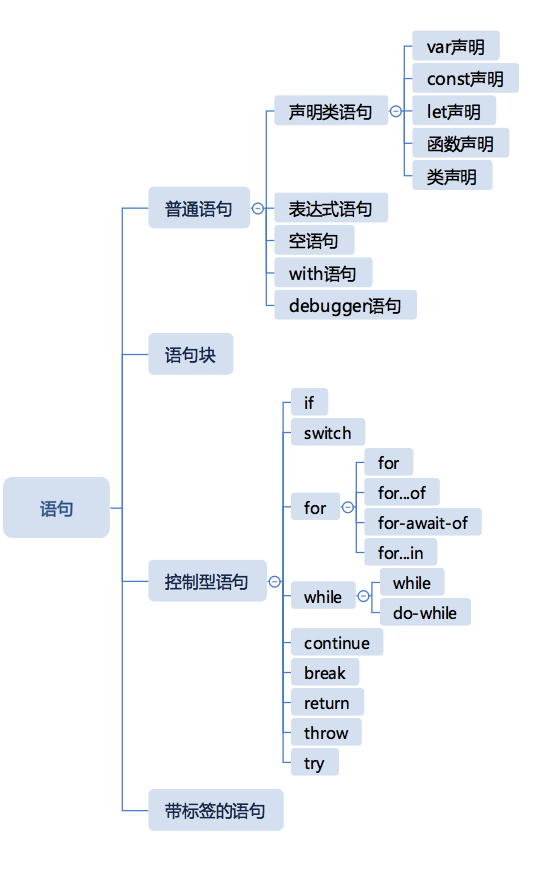


### 普通语种

这些语句在执行时，从前到后顺次执行（我们这里先忽略 var 和函数声明的预处理机制），没有任何分支或者重复执行逻辑。

普通语句执行后，会得到 [[type]] 为 normal 的 Completion Record，JavaScript 引擎遇到这样的 Completion Record，会继续执行下一条语句

这些语句中，只有表达式语句会产生 [[value]]，当然，从引擎控制的角度，这个 value 并没有什么用处。

如果你经常使用 Chrome 自带的调试工具，可以知道，输入一个表达式，在控制台可以得到结果，但是在前面加上 var，就变成了 undefined。

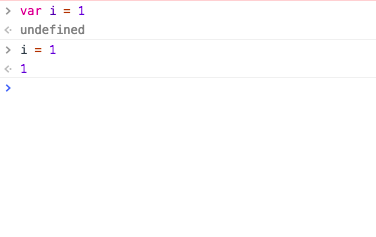

Chrome 控制台显示的正是语句的 Completion Record 的[[value]]。

### 语句块

语句块就是拿大括号括起来的一组语句，它是一种语句的复合结构，可以嵌套。

语句块本身并不复杂，我们需要注意的是语句块内部的语句的 Completion Record 的[[type]] 如果不为 normal，会打断语句块后续的语句执行。

比如我们考虑，一个[[type]]为 return 的语句，出现在一个语句块中的情况。

return 语句可能产生 return 或者 throw 类型的 Completion Record。我们来看一个例子。

In [5]:
{
  var i = 1; // normal, empty, empty
  i ++; // normal, 1, empty
  console.log(i) //normal, undefined, empty
} // normal, undefined, empty

2


我们看到，在一个 block 中，如果每一个语句都是 normal 类型，那么它会顺次执行。接下来我们加入 return 试试看。

In [ ]:
{
  var i = 1; // normal, empty, empty
  return i; // return, 1, empty
  i ++; 
  console.log(i)
} // return, 1, empty

### 控制型语句

控制型语句带有 if、switch 关键字，它们会对不同类型的 Completion Record 产生反应。

一般来说， for/while - break/continue 和 try - throw 这样比较符合逻辑的组合，是大家比较熟悉的，但是，实际上，我们需要控制语句跟 break 、continue 、return 、throw 四种类型与控制语句两两组合产生的效果。

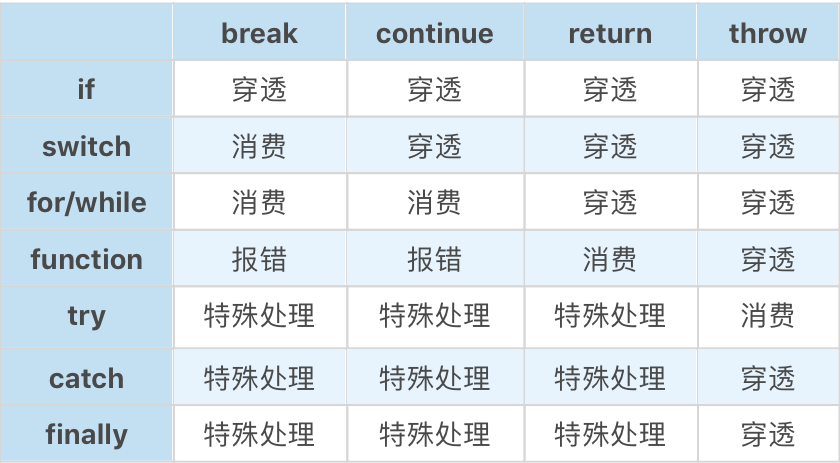

通过这个表，我们不难发现知识的盲点，也就是我们最初的的 case 中的 try 和 return 的组合了。

因为 finally 中的内容必须保证执行，所以 try/catch 执行完毕，即使得到的结果是非 normal 型的完成记录，也必须要执行 finally。

而当 finally 执行也得到了非 normal 记录，则会使 finally 中的记录作为整个 try 结构的结果。

### 带标签的语句

前文我重点讲了 type 在语句控制中的作用，接下来我们重点来讲一下最后一个字段：target，这涉及了 JavaScript 中的一个语法，带标签的语句。实际上，任何 JavaScript 语句是可以加标签的，在语句前加冒号即可：

In [8]:
firstStatement: var i = 1;

大部分时候，这个东西类似于注释，没有任何用处。唯一有作用的时候是：与完成记录类型中的 target 相配合，用于跳出多层循环。

In [9]:
outer: while(true) {
  inner: while(true) {
      break outer;
  }
}
console.log("finished")

finished


break/continue 语句如果后跟了关键字，会产生带 target 的完成记录。一旦完成记录带了 target，那么只有拥有对应 label 的循环语句会消费它。

https://time.geekbang.org/column/article/83860

穿透和消费，报错应该是连贯的，“穿透”就是指不在当前这一层处理，向外逐层寻找可以“消费”的那一层，直到最后都没找到就报错，比如：function里面有while, while里面有switch, switch里面又有continue，按图表来看，switch-continue应该是穿透，向上层寻找消费，碰到while-contine,那就是消费，再如switch里面是return, switch-return穿透，向上层whlie-return穿透，最后function-return是消费。



In [10]:
function test(){
  if(true){
    console.log("111");
    break;
  }
  if(true){
    console.log("222");
  }
}

test(); // SyntaxError: Illegal break statement

//我们可以这么分析：

//1. if 和 break 相遇，break 穿透至 function
//2. function 和 break 相遇，报错


SyntaxError: Illegal break statement

In [11]:
function test() {
  var a = 0;
  switch (a) {
    case 0:
      if (true) {
        console.log("111");
        break;
      }
  }

  if (true) {
    console.log("222");
  }
}

test();
// 111
// 222

//我们可以这么分析：

//1. if 和 break 相遇，break 穿透至 switch
//2. swicth 和 break 相遇，消费掉 break
//3. 接着执行之后的代码

111
222
